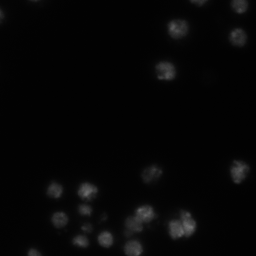

In [1]:
from PIL import Image
Image.open("./input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/images/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png")

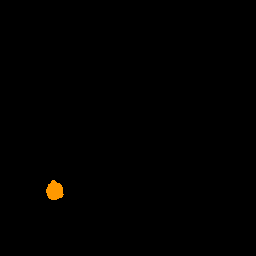

In [2]:
mask = Image.open('./input/stage1_train/00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552/masks/07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask = mask.convert("P")
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [3]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, ""))))
        self.masks = list(sorted(os.listdir(os.path.join(root, ""))))
        # print(self.masks)

    def __getitem__(self, idx):
        # load images and masks
        single_img_path = list(sorted(os.listdir(os.path.join(self.root, self.imgs[idx], "images"))))
        img_path = os.path.join(self.root, self.imgs[idx], "images",single_img_path[0])
        img = Image.open(img_path).convert("RGB")
        # image done

        many_masks_path = list(sorted(os.listdir(os.path.join(self.root, self.imgs[idx], "masks"))))
        many_masks = []
        # print(many_masks_path)
        # making a list of many masks
        lst = list(range(1,len(many_masks_path)+1))
        obj_ids = np.array(lst)
        # print(obj_ids)
        i = 1
        for item in many_masks_path:
            one_mask_path = os.path.join(self.root, self.imgs[idx], "masks", item)
            mask = Image.open(one_mask_path)
            # print(one_mask_path)
            mask = np.array(mask)
            mask = np.where(mask !=0, i, mask)
            many_masks.append(mask)
            i +=1
        # masks path done 
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        # mask = Image.open(mask_path)

        # mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(obj_ids)


        # first id is the background, so remove it
        # obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = many_masks == obj_ids[:, None, None]
        # print("obj_ids shape:")
        # print(obj_ids.shape)
        # print("mask shape:")
        # print(masks.shape)

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        # print(num_objs)
        boxes = []
        for i in range(num_objs):
            # print(masks[i][1])
            # print(masks[i].shape)
            pos = np.where(masks[i])
            # print(pos)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        print("boxes")
        print(boxes)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        print("-----------------end-----------------")
        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
# dataset = PennFudanDataset('PennFudanPed/')
dataset = PennFudanDataset('input/stage1_train/')
dataset[0]

boxes
[[46, 180, 63, 199], [26, 247, 41, 255], [141, 164, 163, 183], [77, 204, 92, 216], [72, 234, 91, 247], [156, 220, 160, 224], [228, 158, 249, 184], [124, 240, 142, 255], [122, 229, 132, 237], [99, 212, 108, 220], [177, 208, 195, 241], [227, 27, 247, 47], [57, 231, 61, 235], [77, 182, 97, 200], [153, 59, 175, 80], [134, 205, 155, 221], [167, 218, 183, 239], [80, 222, 93, 233], [165, 18, 189, 40], [0, 8, 4, 24], [99, 229, 111, 247], [147, 224, 151, 228], [188, 0, 205, 7], [50, 211, 66, 229], [64, 228, 68, 232], [124, 216, 143, 231], [229, 0, 249, 14]]
-----------------end-----------------


(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F8C741E64C0>,
 {'boxes': tensor([[ 46., 180.,  63., 199.],
          [ 26., 247.,  41., 255.],
          [141., 164., 163., 183.],
          [ 77., 204.,  92., 216.],
          [ 72., 234.,  91., 247.],
          [156., 220., 160., 224.],
          [228., 158., 249., 184.],
          [124., 240., 142., 255.],
          [122., 229., 132., 237.],
          [ 99., 212., 108., 220.],
          [177., 208., 195., 241.],
          [227.,  27., 247.,  47.],
          [ 57., 231.,  61., 235.],
          [ 77., 182.,  97., 200.],
          [153.,  59., 175.,  80.],
          [134., 205., 155., 221.],
          [167., 218., 183., 239.],
          [ 80., 222.,  93., 233.],
          [165.,  18., 189.,  40.],
          [  0.,   8.,   4.,  24.],
          [ 99., 229., 111., 247.],
          [147., 224., 151., 228.],
          [188.,   0., 205.,   7.],
          [ 50., 211.,  66., 229.],
          [ 64., 228.,  68., 232.],
          [124., 216., 14

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [6]:
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [7]:
# use our dataset and defined transformations
dataset = PennFudanDataset('input/stage1_train/', get_transform(train=True))
dataset_test = PennFudanDataset('input/stage1_test/', get_transform(train=False))
# dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))

# dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
        params, lr=0.005,
        momentum=0.9, 
        weight_decay=0.0005
)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size=3,
        gamma=0.1
)

In [9]:
# let's train it for 10 epochs
from engine import train_one_epoch, evaluate

num_epochs = 10

for epoch in range(num_epochs):
    print(epoch + 1)
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

1
boxes
[[36, 84, 48, 100], [63, 215, 79, 232], [58, 155, 74, 172], [233, 24, 249, 40], [42, 36, 59, 47], [91, 50, 105, 62], [112, 11, 116, 27], [17, 250, 33, 255], [135, 104, 152, 119], [127, 245, 140, 255]]
-----------------end-----------------
boxes
[[0, 182, 47, 264], [13, 184, 22, 193], [344, 0, 359, 17], [90, 62, 157, 108], [64, 200, 120, 260], [27, 54, 81, 120], [289, 337, 336, 359], [260, 41, 315, 92], [171, 47, 233, 88], [281, 230, 326, 287], [233, 0, 276, 30], [111, 110, 179, 161], [59, 199, 62, 207], [222, 106, 292, 149], [13, 0, 64, 13], [191, 278, 233, 348], [346, 329, 359, 359], [67, 298, 131, 347], [30, 330, 74, 359]]
-----------------end-----------------
boxesboxes

[[243, 142, 269, 164], [132, 20, 142, 33], [208, 36, 213, 42], [83, 127, 107, 152], [163, 28, 178, 51], [28, 97, 44, 117], [243, 48, 250, 54], [286, 18, 293, 26], [25, 199, 36, 212], [0, 172, 2, 183], [21, 18, 34, 30], [17, 132, 40, 155], [301, 206, 309, 212], [178, 5, 209, 35], [88, 247, 98, 255], [209, 93,

ValueError: All bounding boxes should have positive height and width. Found invalid box [0.78125, 303.90625, 0.78125, 347.65625] for target at index 0.

In [ ]:
# pick one image from the test set
img, _ = dataset_test[2]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

In [ ]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

In [ ]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())